Consider this jupyter as a draft of the data processing for the LLM. \
All trials were cleaned and summaried in preprocessing.py function pre_processing_data


In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("credit_risk_reto.csv")

# EDA

1. The dataset consist on 1k rows.
2. Columns Saving accounts and Checking account are the only ones with missing values.

In [3]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [4]:
job_description = {0: "unskilled and non-resident", 1: "unskilled and resident", 2: "skilled", 3: "highly skilled"}
df["Job"] = df["Job"].replace(job_description)

In [5]:
string_columns = df.select_dtypes(include=['object']).columns

for col in string_columns:
    print(f"Unique values in column '{col}':")
    print(df[col].unique())
    print()

Unique values in column 'Sex':
['male' 'female']

Unique values in column 'Job':
['skilled' 'unskilled and resident' 'highly skilled'
 'unskilled and non-resident']

Unique values in column 'Housing':
['own' 'free' 'rent']

Unique values in column 'Saving accounts':
[nan 'little' 'quite rich' 'rich' 'moderate']

Unique values in column 'Checking account':
['little' 'moderate' nan 'rich']

Unique values in column 'Purpose':
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']



In [6]:
df.fillna("no data", inplace=True)

In [7]:
# feature engineering
def categorize_loan(purpose):
    if purpose in ['radio/TV', 'vacation/others']:
        return 'recreational'
    elif purpose in ['education', 'business', 'car']:
        return 'development'
    elif purpose in ['furniture/equipment', 'domestic appliances', 'repairs']:
        return 'maintenance'


# adding columns: "montly_quote", "useful loan" 
df["Monthly_Payment"] = (df["Credit amount"]/df["Duration"]).round(0)
df["Loan Category"] = df["Purpose"].apply(lambda x: categorize_loan(x))

In [8]:
# Define age bins and labels
age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]
age_labels = ['0_20', '21_30', '31_40', '41_50', '51_60', '61_70', '71_80', '81_90', '91_100']

# Create a new column 'Age Group' with the age clusters
df['Age Group'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# Display the first few rows to verify the new column
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Monthly_Payment,Loan Category,Age Group
0,67,male,skilled,own,no data,little,1169,6,radio/TV,195.0,recreational,61_70
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,124.0,recreational,21_30
2,49,male,unskilled and resident,own,little,no data,2096,12,education,175.0,development,41_50
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,188.0,maintenance,41_50
4,53,male,skilled,free,little,little,4870,24,car,203.0,development,51_60


In [9]:
string_columns = df.select_dtypes(include=['object', 'category']).columns

for col in string_columns:
    print(f"Unique values in column '{col}':")
    print(df[col].unique())
    print()

for col in string_columns:
    df[col] = df[col].astype('category')

Unique values in column 'Sex':
['male' 'female']

Unique values in column 'Job':
['skilled' 'unskilled and resident' 'highly skilled'
 'unskilled and non-resident']

Unique values in column 'Housing':
['own' 'free' 'rent']

Unique values in column 'Saving accounts':
['no data' 'little' 'quite rich' 'rich' 'moderate']

Unique values in column 'Checking account':
['little' 'moderate' 'no data' 'rich']

Unique values in column 'Purpose':
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']

Unique values in column 'Loan Category':
['recreational' 'development' 'maintenance']

Unique values in column 'Age Group':
['61_70', '21_30', '41_50', '51_60', '31_40', '71_80', '0_20']
Categories (9, object): ['0_20' < '21_30' < '31_40' < '41_50' ... '61_70' < '71_80' < '81_90' < '91_100']



In [11]:
conversion_dict = {}

for col in string_columns:
    if col == "Job":
        df[col] = df[col].cat.reorder_categories(job_description.values(), ordered=True)
    elif (df[col]=="no data").any():
        unique_values = list(df[col].unique())
        unique_values.remove("no data")
        unique_values
        if col == "Saving accounts":
            df[col] = df[col].cat.reorder_categories(['no data'] + ["little", "moderate", "rich", "quite rich"])
        else:
            df[col] = df[col].cat.reorder_categories(['no data'] + unique_values)
    df[col], conversion_dict[col] = df[col].cat.codes, dict(enumerate(df[col].cat.categories))


['little', 'quite rich', 'rich', 'moderate']
['little', 'moderate', 'rich']


In [12]:
print(json.dumps(conversion_dict, indent=4))

{
    "Sex": {
        "0": "female",
        "1": "male"
    },
    "Job": {
        "0": "unskilled and non-resident",
        "1": "unskilled and resident",
        "2": "skilled",
        "3": "highly skilled"
    },
    "Housing": {
        "0": "free",
        "1": "own",
        "2": "rent"
    },
    "Saving accounts": {
        "0": "no data",
        "1": "little",
        "2": "moderate",
        "3": "rich",
        "4": "quite rich"
    },
    "Checking account": {
        "0": "no data",
        "1": "little",
        "2": "moderate",
        "3": "rich"
    },
    "Purpose": {
        "0": "business",
        "1": "car",
        "2": "domestic appliances",
        "3": "education",
        "4": "furniture/equipment",
        "5": "radio/TV",
        "6": "repairs",
        "7": "vacation/others"
    },
    "Loan Category": {
        "0": "development",
        "1": "maintenance",
        "2": "recreational"
    },
    "Age Group": {
        "0": "0_20",
        "1": "21_

In [14]:
def get_max_account(columns):
    savings_account = columns[0]
    checking_account = columns[1]

    account_category_conversion = {
        "no data": 0,
        "little": 1,
        "moderate": 2,
        "rich": 3,
        "quite rich": 4
    }

    max_account = max(account_category_conversion[savings_account], account_category_conversion[checking_account])

    return [key for key, value in account_category_conversion.items() if value == max_account][0]

In [15]:
# df["Account Size"] = df[["Saving accounts", "Checking account"]].max(axis=1)
df["Account Size"] = df[["Saving accounts", "Checking account"]].apply(get_max_account, axis=1)

In [16]:
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Monthly_Payment,Loan Category,Age Group,Account Size
0,67,male,skilled,own,no data,little,1169,6,radio/TV,195.0,recreational,61_70,little
1,22,female,skilled,own,little,moderate,5951,48,radio/TV,124.0,recreational,21_30,moderate
2,49,male,unskilled and resident,own,little,no data,2096,12,education,175.0,development,41_50,little
3,45,male,skilled,free,little,little,7882,42,furniture/equipment,188.0,maintenance,41_50,little
4,53,male,skilled,free,little,little,4870,24,car,203.0,development,51_60,little
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,female,unskilled and resident,own,little,no data,1736,12,furniture/equipment,145.0,maintenance,31_40,little
996,40,male,highly skilled,own,little,little,3857,30,car,129.0,development,41_50,little
997,38,male,skilled,own,little,no data,804,12,radio/TV,67.0,recreational,31_40,little
998,23,male,skilled,free,little,little,1845,45,radio/TV,41.0,recreational,21_30,little


(array([20., 23., 20., 19.,  9.,  2.,  4.,  1.,  0.,  1.]),
 array([ 30. ,  87.4, 144.8, 202.2, 259.6, 317. , 374.4, 431.8, 489.2,
        546.6, 604. ]),
 <BarContainer object of 10 artists>)

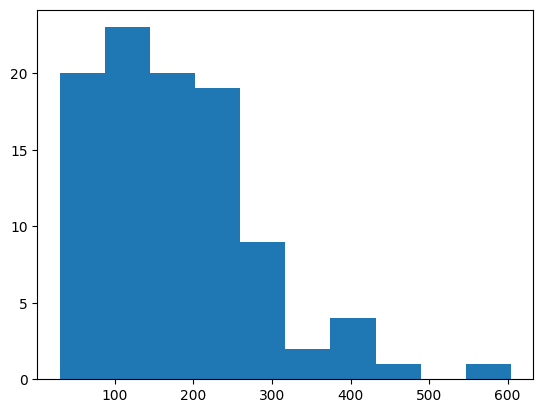

In [14]:
plt.hist(df[df["Account Size"] == 0]["Monthly_Payment"])

In [17]:
# Function to remove outliers from a pandas Series based on the IQR method (boxplot parameters)
def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

# Group by 'Account Size' and remove outliers for 'Monthly_Payment'
df_no_outliers = df.groupby('Account Size')['Monthly_Payment'].apply(remove_outliers).reset_index(level=0)

# Calculate median and standard deviation for each group
account_size_stats = df_no_outliers.groupby('Account Size')['Monthly_Payment'].agg(['median', 'std']).round({'std': 0}).to_dict()


In [22]:
account_size_stats

{'median': {'little': 125.0,
  'moderate': 130.5,
  'no data': 160.0,
  'quite rich': 118.0,
  'rich': 120.0},
 'std': {'little': 75.0,
  'moderate': 85.0,
  'no data': 90.0,
  'quite rich': 63.0,
  'rich': 53.0}}

In [18]:
def get_monthly_payment_stats(account_size, monthly_payment):
    global account_size_stats
    mean = account_size_stats["median"][account_size]
    std = account_size_stats["std"][account_size]
    if monthly_payment > mean + std:
        return "high"
    else:
        return "normal"

In [19]:
# conversion_dict["Account Size"] = conversion_dict["Saving accounts"]
df["High Monthly_Payment"] = df[["Account Size", "Monthly_Payment"]].apply(lambda x: get_monthly_payment_stats(*x), axis=1).astype('category')
df.drop(columns=["Saving accounts", "Checking account", "Age"], inplace=True)

In [18]:
col = "High Monthly_Payment"
df[col], conversion_dict[col] = df[col].cat.codes, dict(enumerate(df[col].cat.categories))

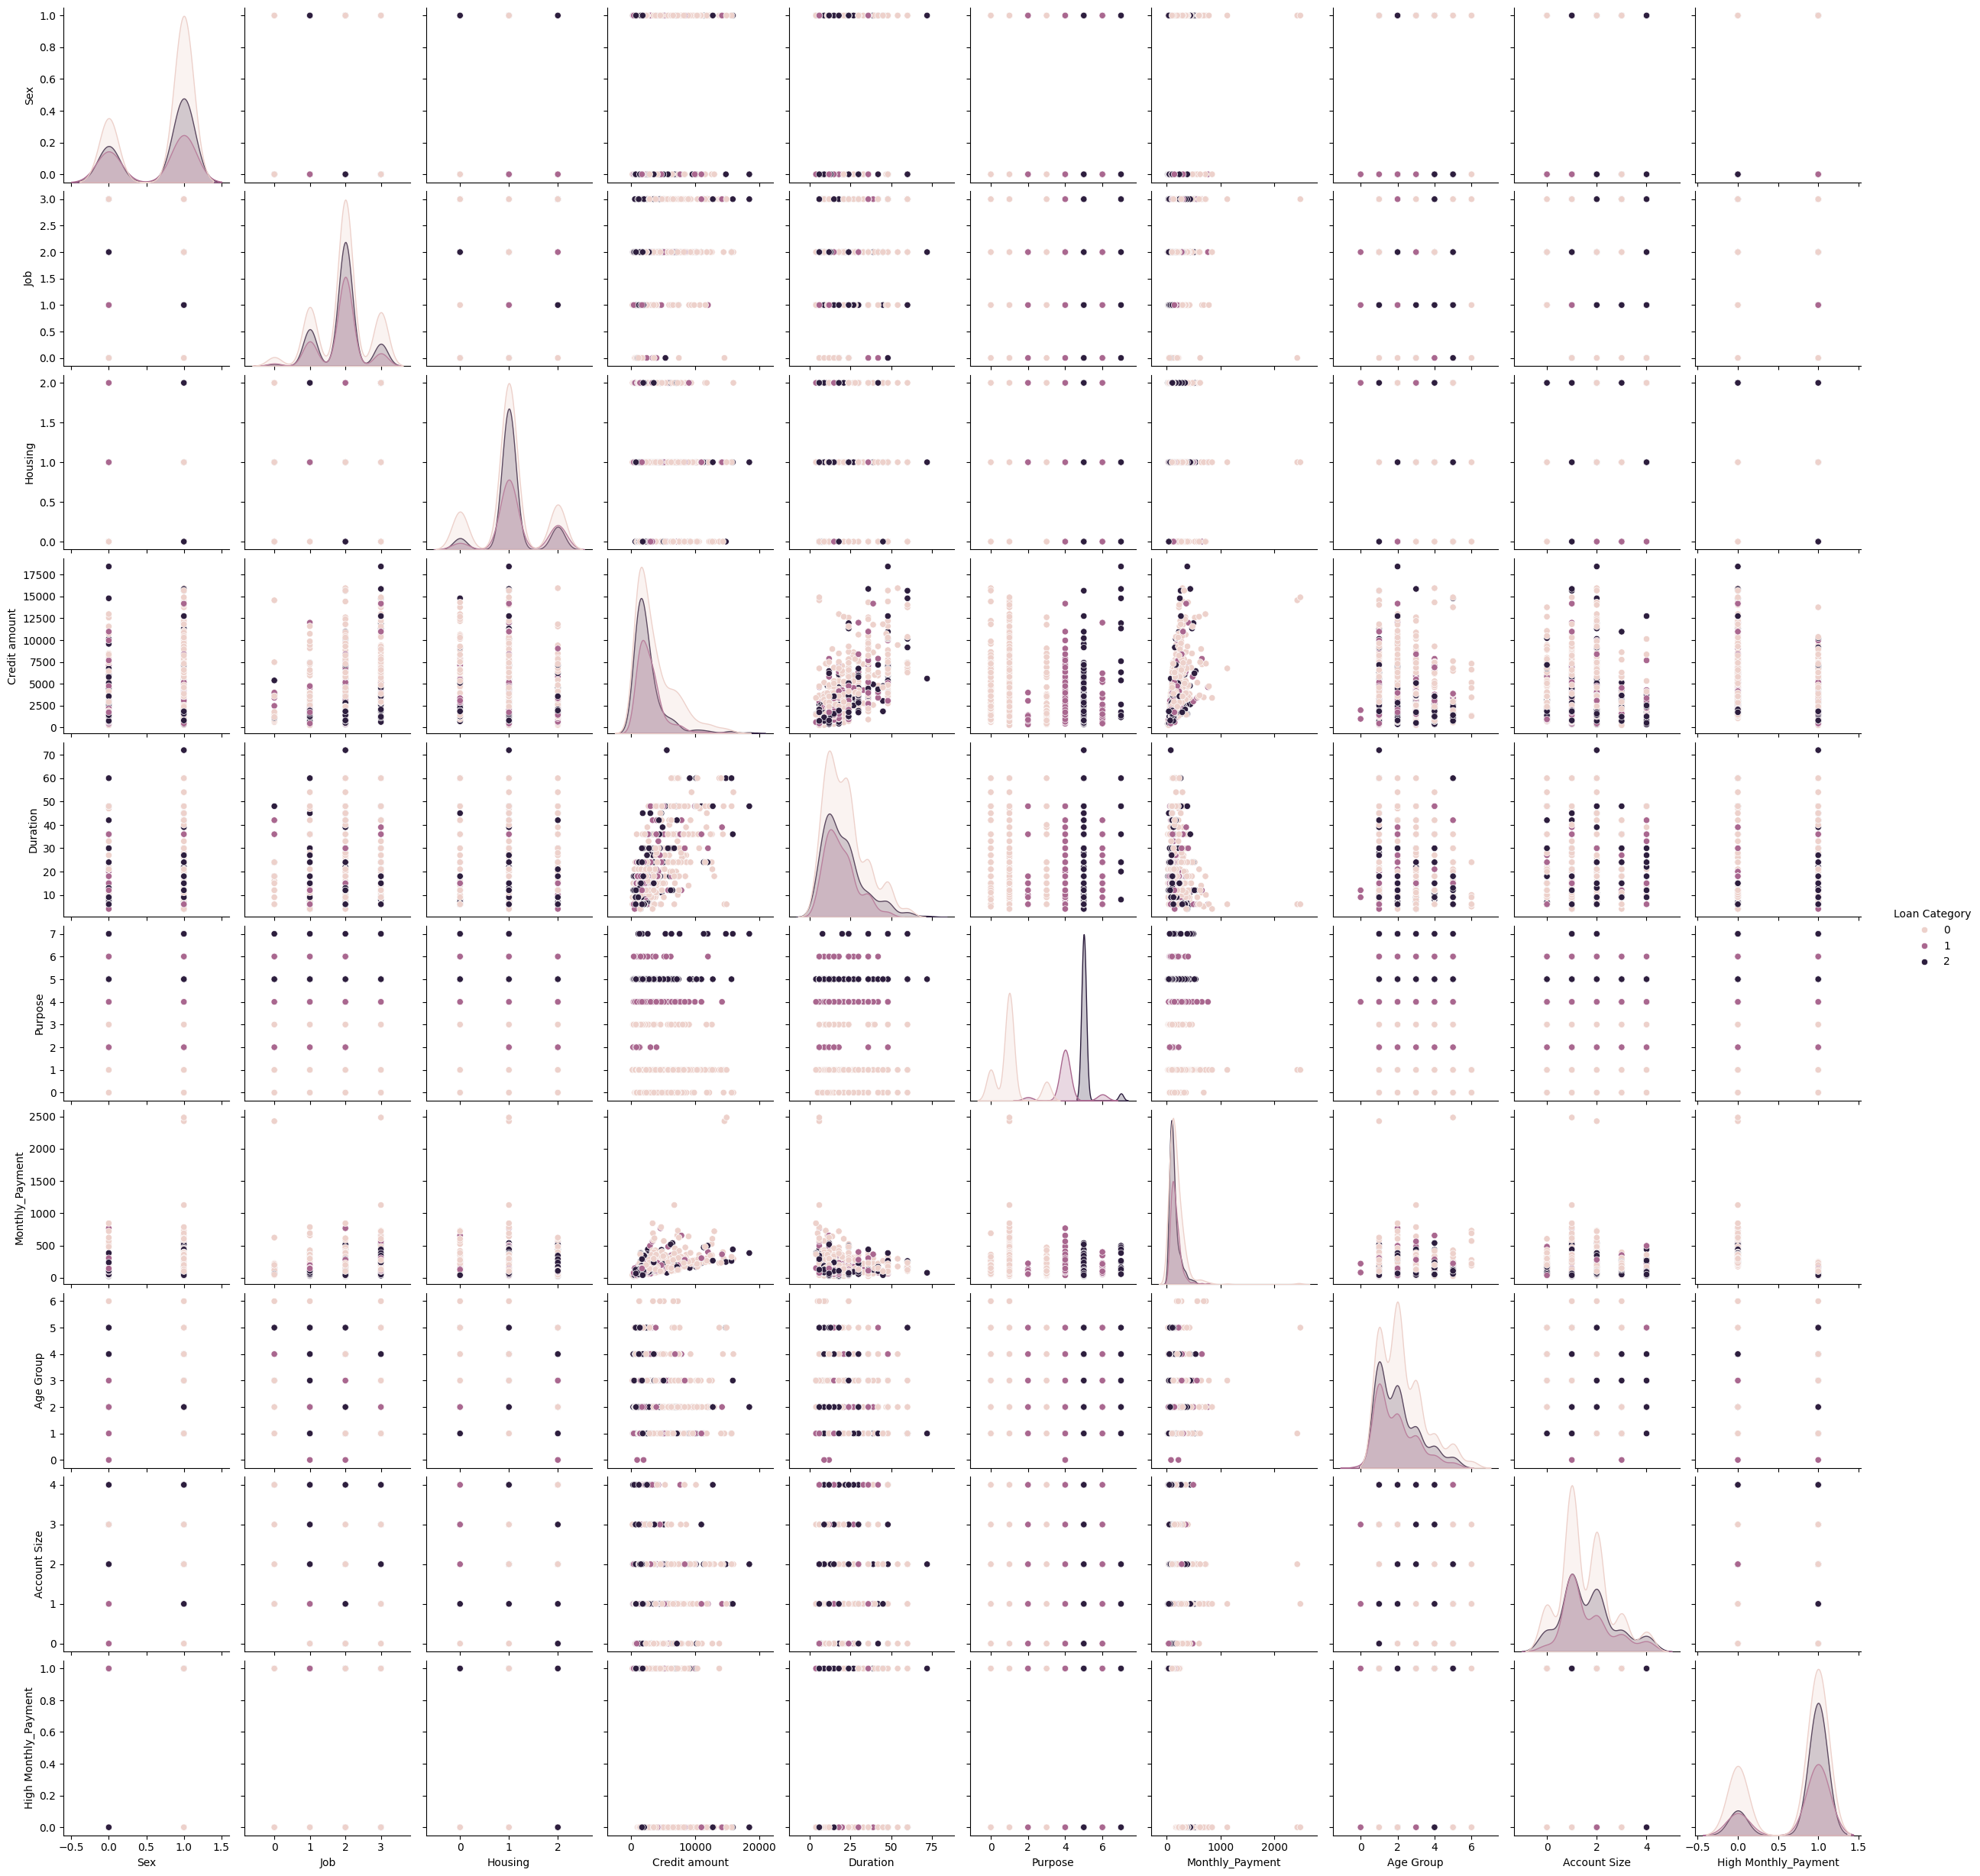

In [18]:
sns.pairplot(df, hue="Loan Category")
plt.show()

In [19]:
df_train_knn = df.copy()

In [20]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Split the data into train and test sets with stratification
train_df, test_df = train_test_split(df_train_knn, test_size=0.1, stratify=df_train_knn['Loan Category'], random_state=42)

# Create and fit the KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train_df)

# Predict the clusters for the test set
train_df['Cluster'] = kmeans.predict(train_df)
test_df['Cluster'] = kmeans.predict(test_df)


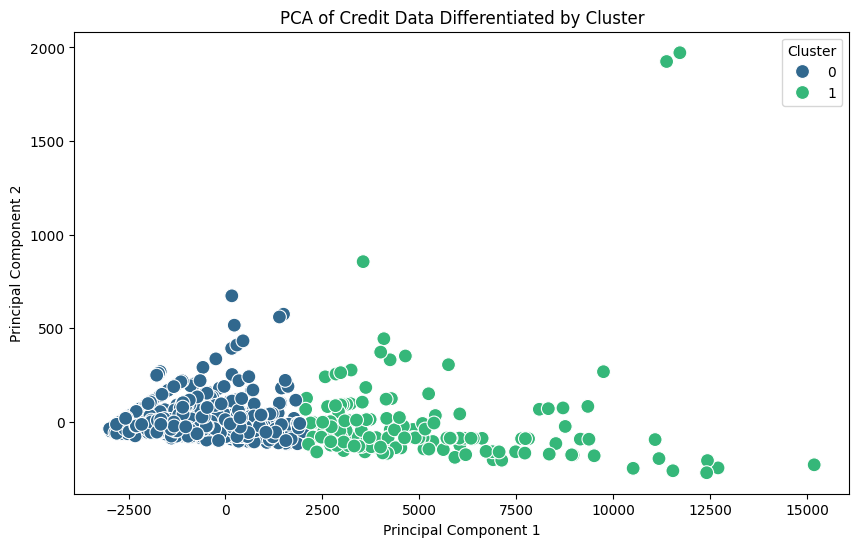

In [21]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(train_df.drop(columns=['Cluster']))

# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = train_df['Cluster'].values

# Plot the PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=100)
plt.title('PCA of Credit Data Differentiated by Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [22]:
df_converted = df.copy()

for col, mapping in conversion_dict.items():
    if col in df_converted.columns:
        df_converted[col] = df_converted[col].map(mapping)

df_converted.head()

,Sex,Job,Housing,Credit amount,Duration,Purpose,Monthly_Payment,Loan Category,Age Group,Account Size,High Monthly_Payment
0,male,skilled,own,1169,6,radio/TV,195.0,recreational,61_70,little,normal
1,female,skilled,own,5951,48,radio/TV,124.0,recreational,21_30,moderate,normal
2,male,unskilled and resident,own,2096,12,education,175.0,development,41_50,little,normal
3,male,skilled,free,7882,42,furniture/equipment,188.0,maintenance,41_50,little,normal
4,male,skilled,free,4870,24,car,203.0,development,51_60,little,high


In [23]:
df_converted.to_csv("credit_risk_reto_processed.csv", index=False)

In [ ]:
df_converted["High Monthly_Payment"].value_counts()

You are a credit analysist, deciding if a given loan is good or bad. "good", the loan should be paid without issues. "bad", it is probable thatis paid in delay or not paid at all.
Consider the following variables to decide:
- Type of job: {{job}}. Options ["unskilled and non-resident", "unskilled and resident", "skilled", "highly skilled"]
- Housing Situation: {{housing}}. Options: ["free", "own", "rent"]
- Loan Category: {{category}}. Options: ["self development", "maintenance", "recreational"]
- Account Size: {{account}}. Options: ["no data", "little", "moderate", "rich", "quite rich"]
- Monthly Payment in usd: {{monthly_payment}}. Numerical type.
Just respond in json format, with the "loan": "bad" or "good". 

In [25]:
import boto3
from tqdm.notebook import tqdm

In [26]:
client = boto3.client('bedrock-runtime', region_name='us-east-1')

In [41]:
def return_prompt(job, housing, category, account, high_payment, months):
    return f"You are a credit analyst, deciding if a given loan is good or bad. 'good', the loan should be paid without issues. 'bad', it is probable that it is paid in delay or not paid at all. Consider the following variables to decide: Type of job: '{job}'. Options ['unskilled and non-resident', 'unskilled and resident', 'skilled', 'highly skilled']. Housing Situation: '{housing}'. Options: ['free', 'own', 'rent']. Loan Category: '{category}'. Options: ['self development', 'maintenance', 'recreational']. Account Size: '{account}'. Options: ['no data', 'little', 'moderate', 'rich', 'quite rich']. High Monthly Payment: '{high_payment}'. Options: ['normal', 'high']. Duration (in months): {months}. Just respond in json format, with the 'loan': 'bad' or 'good'."

In [42]:
import tiktoken
tokenizer = tiktoken.get_encoding("cl100k_base")

In [49]:
tokens = []
for i, row in tqdm(df_converted.iterrows(), total=len(df_converted)):
    job = row["Job"]
    housing = row["Housing"]
    category = row["Loan Category"]
    account = row["Account Size"]
    high_payment = row["High Monthly_Payment"]
    months = row["Duration"]
    kwargs = {
        "job": job,
        "housing": housing,
        "category": category,
        "account": account,
        "high_payment": high_payment,
        "months": months
    }
    prompt = return_prompt(**kwargs)
    tokenizer = tiktoken.get_encoding("cl100k_base")
    tokens.append(len(tokenizer.encode(prompt)))

df_converted["Prompt Length"] = tokens

  0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
prices = {"mistral.mistral-small-2402-v1:0": 0.001 * 10**-3}

In [60]:
print(f"Running mistral small with cost: {prices['mistral.mistral-small-2402-v1:0']*df_converted['Prompt Length'].sum()} USD")
# We can neglect the output cost because it is very small response

Running mistral small with cost: 0.191899 USD


### Running Mistral

In [71]:
import time

def call_model(model_id, prompt):
    response = client.invoke_model(
    modelId=model_id,
    contentType="application/json",
    accept="application/json",
    body=f"{{\"prompt\":\"<s>[INST] {prompt} [/INST]\", \"max_tokens\":12, \"temperature\":0, \"top_p\":1, \"top_k\":10}}"
    )

    # return json.loads(json.loads(response["body"].read().decode("utf-8"))["outputs"][0]["text"])
    return response["body"].read().decode("utf-8")

model_id = "mistral.mistral-small-2402-v1:0"

responses = []
for i, row in tqdm(df_converted.iterrows(), total=len(df_converted)):
    job = row["Job"]
    housing = row["Housing"]
    category = row["Loan Category"]
    account = row["Account Size"]
    high_payment = row["High Monthly_Payment"]
    months = row["Duration"]
    kwargs = {
        "job": job,
        "housing": housing,
        "category": category,
        "account": account,
        "high_payment": high_payment,
        "months": months
    }
    prompt = return_prompt(**kwargs)

    retries = 0
    while retries < 5:
        try:
            response = call_model(model_id, prompt)
            responses.append(response)
            break
        except client.exceptions.ThrottlingException:
            wait_time = 2 ** retries
            print(f"{i} ThrottlingException: Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
            retries += 1
    else:
        print("Failed to get response after multiple retries.")
        responses.append(None)

    time.sleep(5)

  0%|          | 0/1000 [00:00<?, ?it/s]

1 ThrottlingException: Retrying in 1 seconds...
3 ThrottlingException: Retrying in 1 seconds...
4 ThrottlingException: Retrying in 1 seconds...
6 ThrottlingException: Retrying in 1 seconds...
7 ThrottlingException: Retrying in 1 seconds...
8 ThrottlingException: Retrying in 1 seconds...
9 ThrottlingException: Retrying in 1 seconds...
11 ThrottlingException: Retrying in 1 seconds...
14 ThrottlingException: Retrying in 1 seconds...
15 ThrottlingException: Retrying in 1 seconds...
16 ThrottlingException: Retrying in 1 seconds...
18 ThrottlingException: Retrying in 1 seconds...
24 ThrottlingException: Retrying in 1 seconds...
25 ThrottlingException: Retrying in 1 seconds...
26 ThrottlingException: Retrying in 1 seconds...
27 ThrottlingException: Retrying in 1 seconds...
29 ThrottlingException: Retrying in 1 seconds...
33 ThrottlingException: Retrying in 1 seconds...
34 ThrottlingException: Retrying in 1 seconds...
35 ThrottlingException: Retrying in 1 seconds...
36 ThrottlingException: Ret

In [127]:
clasifications = []
for response in responses:
    try:
        clasification = json.loads(json.loads(response)['outputs'][0]['text'])['loan']
    except:
        string_with_info = json.loads(response)["outputs"][0]["text"].replace("{\n", "").replace("risky", 'risky"').strip()
        clasification = string_with_info.split(":")[1].strip().replace('"', "")
    clasifications.append(clasification)

In [130]:
df_converted["Prediction Mistral Small"] = clasifications

In [133]:
df_converted["Prediction Mistral Small"] = df_converted["Prediction Mistral Small"].replace("potentially risky", "bad")
df_converted["Prediction Mistral Small"].value_counts()

Prediction Mistral Small
good    813
bad     187
Name: count, dtype: int64

In [134]:
df_converted.to_csv("credit_risk_reto_processed.csv", index=False)